In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

In [24]:
# Load the dataset
dataset = pd.read_csv("train.csv")

# Add TotalBathrooms feature
if 'FullBath' in dataset.columns and 'HalfBath' in dataset.columns:
    dataset['TotalBathrooms'] = dataset['FullBath'] + (0.5 * dataset['HalfBath'])
else:
    raise ValueError("Missing 'FullBath' or 'HalfBath' columns in dataset.")

# Select useful numeric and categorical columns
num_cols = ['LotArea', 'OverallQual', 'YearBuilt', 'GrLivArea',
            'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'TotalBathrooms']  # include TotalBathrooms
cat_cols = ['Neighborhood', 'HouseStyle']
selected_cols = num_cols + cat_cols + ['SalePrice']

# Filter dataset
features = dataset[selected_cols]

# Separate into X and y
X = features.drop("SalePrice", axis=1)
y = features["SalePrice"]


features_encoded = pd.get_dummies(features, columns=['Neighborhood', 'HouseStyle'], drop_first=True)
print(features_encoded.head())

In [25]:
print("Missing values in each column:\n", features.isnull().sum())
print("\nShape before encoding:", X.shape)


Missing values in each column:
 LotArea           0
OverallQual       0
YearBuilt         0
GrLivArea         0
GarageCars        0
TotalBsmtSF       0
1stFlrSF          0
TotalBathrooms    0
Neighborhood      0
HouseStyle        0
SalePrice         0
dtype: int64

Shape before encoding: (1460, 10)


In [26]:
print(features.head())

   LotArea  OverallQual  YearBuilt  GrLivArea  GarageCars  TotalBsmtSF  \
0     8450            7       2003       1710           2          856   
1     9600            6       1976       1262           2         1262   
2    11250            7       2001       1786           2          920   
3     9550            7       1915       1717           3          756   
4    14260            8       2000       2198           3         1145   

   1stFlrSF  TotalBathrooms Neighborhood HouseStyle  SalePrice  
0       856             2.5      CollgCr     2Story     208500  
1      1262             2.0      Veenker     1Story     181500  
2       920             2.5      CollgCr     2Story     223500  
3       961             1.0      Crawfor     2Story     140000  
4      1145             2.5      NoRidge     2Story     250000  


In [27]:
features_encoded = pd.get_dummies(features, columns=['Neighborhood', 'HouseStyle'], drop_first=True)
x = features_encoded.drop('SalePrice', axis=1)
y = features_encoded['SalePrice']
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=1
)


In [28]:
# Define the hyperparameter grid
param_dist = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Setup the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=1),
    param_distributions=param_dist,
    n_iter=20,             # Try 20 random combinations
    cv=5,                  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1,             # Use all available cores
    scoring='neg_mean_absolute_error',
    random_state=1
)

# Run the search
random_search.fit(x_train, y_train)

# Get the best model
best_rf_model = random_search.best_estimator_

print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}


In [29]:
xgb_model = XGBRegressor(random_state=1)
xgb_model.fit(x_train, y_train)
xgb_pred = xgb_model.predict(x_test)

In [30]:
y_pred = best_rf_model.predict(x_test)

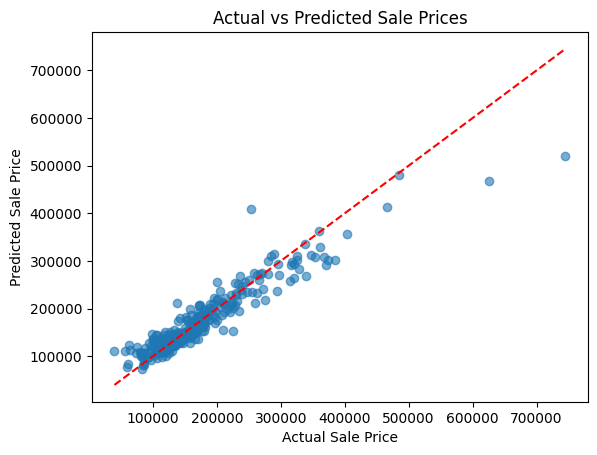

In [31]:
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Ideal line
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs Predicted Sale Prices")
plt.show()


In [32]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [33]:
# printing the values
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.4f}")

MAE: 18552.05
MSE: 883109903.92
R² Score: 0.8762


In [34]:
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

print("XGBoost MAE:", round(xgb_mae, 2))
print("XGBoost MSE:", round(xgb_mse, 2))
print("XGBoost R² Score:", round(xgb_r2, 4))


XGBoost MAE: 18822.98
XGBoost MSE: 844257280.0
XGBoost R² Score: 0.8816


In [35]:
models = ['Random Forest', 'XGBoost']
maes = [mae, xgb_mae]
r2s = [r2, xgb_r2]

for name, m, r in zip(models, maes, r2s):
    print(f"{name}: MAE = {round(m,2)}, R² = {round(r,4)}")


Random Forest: MAE = 18552.05, R² = 0.8762
XGBoost: MAE = 18822.98, R² = 0.8816


In [36]:
joblib.dump(best_rf_model, "random_forest_model.pkl")
joblib.dump(xgb_model, "xgboost_model.pkl")



['xgboost_model.pkl']